# Oil Spill Detection: Image Preprocessing 1



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Introduction

In this project, we will use satellite radar images to automatically identify oil spill in the ocean using deep learning.

The data is part of the [Slick in a Haystack](https://xeek.ai/challenges/slick-in-a-haystack-a-localization-challenges) challenge. This notebook is based on the starter notebook of the contest. 

More than 4000 hi-resolution images were provided. Although, those are large images to feed to a deep learning algorithm, and we will work on patch them into smaller images with 128 by 128 pixels.

Also, the "mask" (location of the spill) is in a `json` file (low_resolution_train.json), which is a text file. We will convert it to image masks.

# Importing Libraries

In [2]:
# Installing patchify in Google Colab
! pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import cv2      # OpenCV library for computer vision
import json     # To work with json files
import random as rnd
import copy
import sys
from patchify import patchify       # To patch the images
from tqdm import tqdm
import numpy as np

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'figure.max_open_warning': 0})

# Working with directories
from glob import glob
import os


# Loading the Data

Image files (tiff) were provided. So we will load them,, as well the json file.

In [4]:
# Folders locations
DATA_ROOT = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train"
MASK_ROOT = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Masks"
SAVE_ROOT = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img"
RAW_DATASET_FOLDER = f"{DATA_ROOT}"
GROUND_TRUTH_FEATURES_FILENAME = f"{DATA_ROOT}/low_resolution_train.json"

In [5]:
# Loading json file
with open(GROUND_TRUTH_FEATURES_FILENAME, 'r') as f:
    GROUND_TRUTH_FEATURES = json.load(f)

In [6]:
GROUND_TRUTH_FEATURES

{'892': [[3403, 3014, 3448, 3236]],
 '2589': [[4074, 1132, 4099, 1152], [4416, 1383, 4483, 1412]],
 '2554': [[3669, 1948, 3749, 2005],
  [3294, 1990, 3305, 2002],
  [3274, 2013, 3290, 2021],
  [5218, 1875, 5222, 1888],
  [4454, 1972, 4460, 1978],
  [2429, 3148, 2437, 3158]],
 '214': [[3567, 3713, 3656, 3780]],
 '274': [[2651, 3742, 2696, 3845],
  [4603, 1463, 4632, 1478],
  [4555, 1565, 4574, 1580],
  [4712, 1363, 4740, 1389],
  [4564, 1500, 4583, 1515],
  [4420, 1632, 4440, 1648]],
 '4265': [[3586, 510, 3753, 611]],
 '316': [[3651, 2635, 3658, 2643], [5047, 2897, 5060, 2903]],
 '2255': [[3733, 602, 3823, 641],
  [3089, 1103, 3266, 1226],
  [4191, 342, 4244, 400],
  [2797, 542, 2805, 571],
  [4286, 552, 4356, 636],
  [2955, 568, 3011, 636],
  [2907, 626, 2940, 651],
  [4173, 615, 4231, 657],
  [2960, 572, 3035, 659],
  [4349, 690, 4361, 711],
  [3868, 701, 3944, 745],
  [2759, 946, 2766, 959],
  [2716, 1829, 2729, 1849],
  [4222, 2503, 4246, 2524],
  [5004, 2963, 5014, 3016],
  [3664, 

Getting image files names for specific extensions:

In [7]:
def read_image_filenames(path):
    extensions = ["*.tif", "*.tiff", "*.jpeg", "*.jpg"]
    image_filenames = []
    for ext in extensions:
        image_filenames.extend(glob(os.path.join(path, ext)))
    return image_filenames

original_image_filenames = read_image_filenames(RAW_DATASET_FOLDER)

original_image_filenames[:10]

['/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4077.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4078.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4079.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4080.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4081.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4082.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4083.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4084.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4085.tif',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/4086.tif']

## Data Visualization

Creating functions to read and visualize the images and targets.

In [8]:
# Read the image
def read_image(image_filename):
    image = cv2.imread(image_filename)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [9]:
# Convert json information to numpy array to print over the images
def read_image_features(image_filename, all_features = GROUND_TRUTH_FEATURES):
    """
    Reads image features with their coordinates.
    Returns features dictionary with (x,y) coordinates as a NumPy array, adjusted to match the image coordinates (i.e. (0,0) in the left/upper corner).
    """
    image_name = os.path.splitext(os.path.basename(image_filename))[0]
    image_features = all_features.get(image_name, [])
        
    return np.array(image_features).astype(np.int32)

In [10]:
# Print images with marker
def scale_image_with_features(image, features, scale_factor=None):
    """
    Scales image with corresponding features.
    If the scale_factor parameter is not provided, it is selected automatically.
    The typical values of scale_factor should be between 0 (exclusive) and 1 (inclusive).
    Returns resized image, adjustes features list and scale factor.
    """
    if not scale_factor:
        s0 = 1000/image.shape[0]
        s1 = 2000/image.shape[1]
        scale_factor = max(s0, s1)
    
    # Resize image
    res_img = cv2.resize(image, dsize=(0,0), fx=scale_factor, fy=scale_factor)
    
    # Scale features coordinates to match the resized image
    if len(features) > 0 and scale_factor != 1:
        res_features = np.array(copy.deepcopy(features))
        res_features = (res_features * scale_factor).astype(np.int32)
    else:
        res_features = features
        
    return res_img, res_features, scale_factor

Visualize one image to test the functions:

[[2327 2433 2444 2476]
 [2331 2320 2371 2342]
 [1940 2053 1956 2062]]
(1588, 2000, 3)


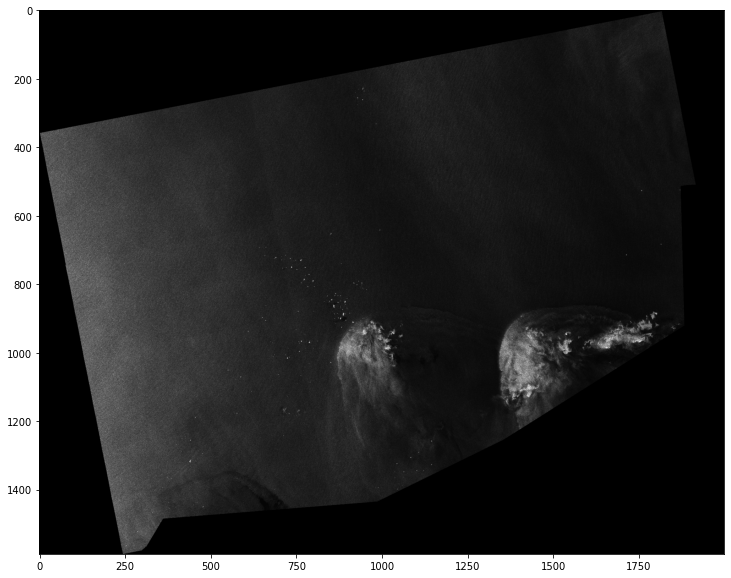

In [11]:
fil = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/Train/2445.tif"

img = read_image(fil)
feat = read_image_features(fil)

img_s, feat_s, sf = scale_image_with_features(img, feat)
print(feat)
print(img_s.shape)
plt.figure(figsize = (13,10))
plt.imshow(img_s, cmap = "gray");

In [12]:
def add_features_to_image(image, features):
    """
    Draws feature polygons on image and returns new, annotated image.
    """
    
    if len(features) == 0:
        return image
    
    # Preserving original image (TBC)    
    ann_img = image.copy()

    for f in features:        
        coords =  np.array(f)
        ann_img = cv2.rectangle(ann_img, coords[:2], coords[-2:], color=(255,0,0), thickness=1, lineType=cv2.LINE_8)

    return ann_img

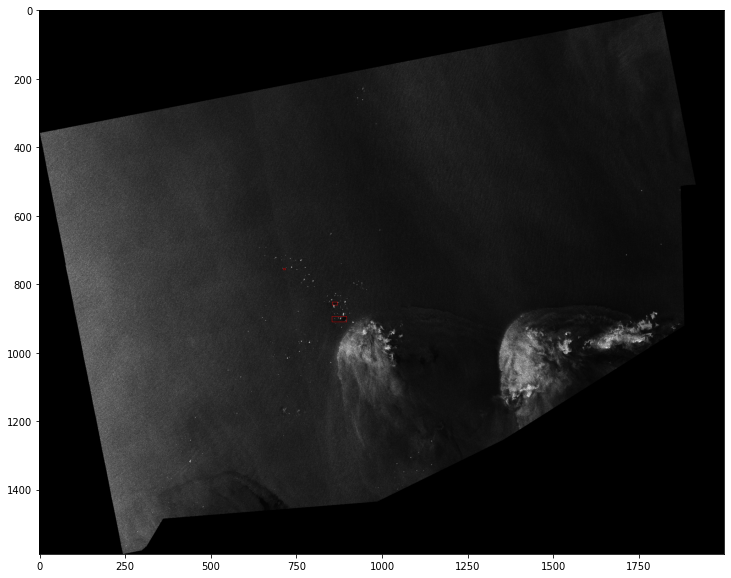

In [13]:
fig = add_features_to_image(img_s, feat_s)
plt.figure(figsize = (13,10))
plt.imshow(fig, cmap = "gray")

## Generating Masks

We will use the information in the `json` file to create a binary mask (oil, not-oil), which is an image with the same size as the satellite one, but only with zeroes and ones.

In [14]:
# Create binary masks from polygon coordinates
def create_binary_masks(im, feat):

  # Create image of zeroes with same size as im  
  blank = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)

  # For each event, create a rectangle of ones in the image
  for f in feat:        
    temp =  np.array(f)

    coords = np.array([[temp[0], temp[1]], [temp[0], temp[3]], [temp[2], temp[3]], [temp[2], temp[1]]], "int32")

    blank = cv2.fillConvexPoly(blank, coords, 255)

  return blank

Testing the function:

(1588, 2000)


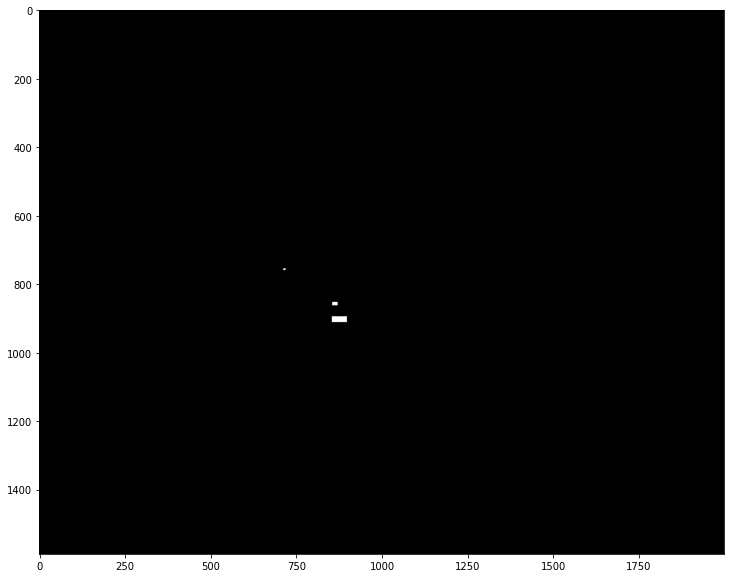

In [15]:
mask = create_binary_masks(img_s, feat_s)
plt.figure(figsize = (13,10))
plt.imshow(mask, cmap = "gray")
print(mask.shape)

In [18]:
img_s.shape

(1588, 2000, 3)

# Splitting the images and saving to disk

Using the `patchify` library, we will split the large images into small ones (for both the satellite and masks), and save to disk.

In [17]:
# Testing
patches = patchify(img_s, (128, 128, 3), step = 100)
print(patches.shape)

(15, 19, 1, 128, 128, 3)


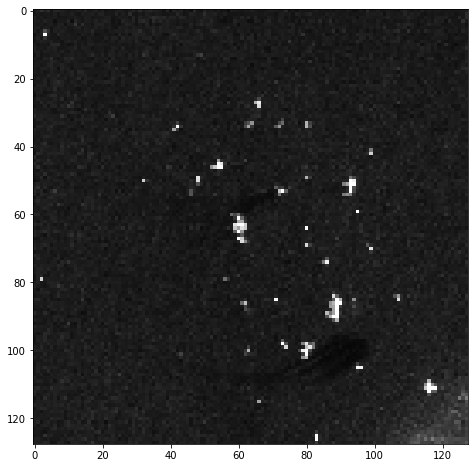

In [21]:
plt.figure(figsize = (8,8))
plt.imshow(patches[8,8,0,:,:,:]);

Creating functions:

In [22]:
def read_image_and_features(image_filename):
    image = read_image(image_filename)
    image_features = read_image_features(image_filename)

    res_img, res_features, scale_factor = scale_image_with_features(image, image_features)
    
    return res_img, res_features

In [23]:
def create_binary_masks(im, feat):
    
  blank = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)

  for f in feat:        
    temp =  np.array(f)

    coords = np.array([[temp[0], temp[1]], [temp[0], temp[3]], [temp[2], temp[3]], [temp[2], temp[1]]], "int32")

    blank = cv2.fillConvexPoly(blank, coords, 255)

  return blank

In [19]:
def create_split_image_and_masks(image_filename, mask_folder = MASK_ROOT, new_image_folder = SAVE_ROOT, size = (128, 128, 3), step = 100):

  # Creating metafile info
  image_number = int(os.path.splitext(os.path.basename(image_filename))[0]) * 1000

  # Reading image
  im, feat = read_image_and_features(image_filename)

  # Create mask
  mask = create_binary_masks(im, feat) * 255
  mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

  # Split image and mask
  im_patches = patchify(im, patch_size = size, step = step)
  mask_patches = patchify(mask_rgb, patch_size = size, step = step)

  # Select images and patches that contain features and save images and masks patches to disk
  k = 1
  if np.sum(mask) > 0:
    # print(f"Image {int(image_number/1000)} contains features. Splitting into patches and saving the files")

    # Looping through all patches
    for i in range(im_patches.shape[0]):
      for j in range(im_patches.shape[1]):

        # Selecting patches with features
        if np.sum(mask_patches[i,j,0,:,:,:]) > 0:

          # Saving satellite image
          cv2.imwrite(new_image_folder + f"/{image_number + k}.png", im_patches[i,j,0,:,:,:])

          # Saving mask
          cv2.imwrite(mask_folder + f"/{image_number + k}.png", mask_patches[i,j,0,:,:,:])
        
        # Patch location
        k = k + 1
  
  else:
    print(f"Image {int(image_number/1000)} doesn't contain any feature. No files were saved.")

In [ ]:
# Loop through all images:
for image_file in tqdm(original_image_filenames):
  create_split_image_and_masks(image_file, size = (128,128,3), step = 100)

  1%|          | 39/4038 [01:18<2:08:00,  1.92s/it]